In [ ]:
# Aqui está sendo instalada as bibliotecas essenciais para projetos com redes neurais e visualização em Python.
# Torch - Usada para criar, treinar e executar redes neurais.
# Torchvision - Biblioteca que faz parte do Pytorch, com ferramentas para visão computacional.
# Matplotlib - Biblioteca para visualização de dados - Gráficos, imagens-

!pip install -q torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00


In [ ]:
import torch  # Biblioteca principal do PyTorch para tensores e deep learning
import torch.nn as nn # Módulo para definir e treinar redes neurais
import torch.nn.functional as F  # Funções como ReLU, convolução e perdas, usadas diretamente.
import matplotlib.pyplot as plt  # Visualização de imagens e gráficos
import numpy as np  # manipulação de arrays e operações matemáticas
from torchvision import transforms # Conjunto de transformações para pré-processar imagen
from PIL import Image # Leitura e manipulação de imagens
from io import BytesIO # Manipulação de arquivos em memória (como uploads de imagem)
import ipywidgets as widgets  # Criação de widgets interativos no Jupyter Notebook
from IPython.display import display # Mostra widgets e imagens diretamente no notebook
from google.colab import files
import cv2  # Biblioteca para processamento de imagens

Faça upload de 5 máscaras:


Saving 3.png to 3 (1).png
Saving 4.png to 4 (2).png
Saving 5.png to 5 (2).png
Saving 6.png to 6 (2).png
Saving cate1-00001.png to cate1-00001 (1).png
Epoch 0, Loss médio: 0.6645
Epoch 10, Loss médio: 0.5661
Epoch 20, Loss médio: 0.1920
Epoch 30, Loss médio: 0.0214
Epoch 40, Loss médio: 0.0111
Teste 1: Loss = 0.0180


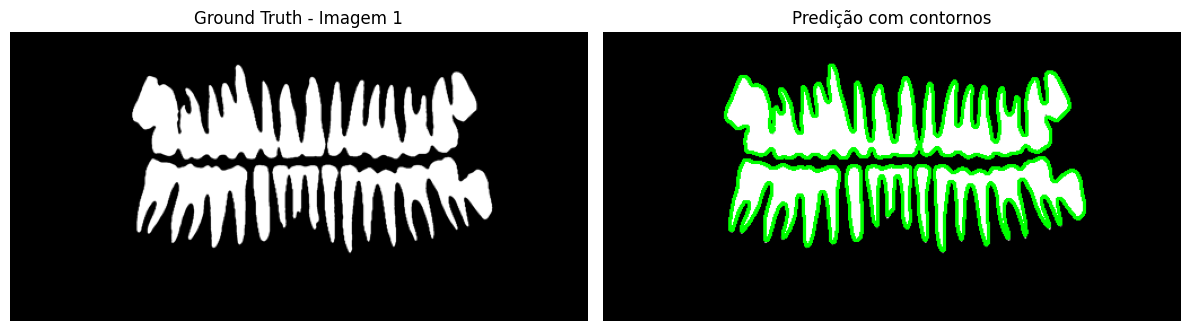

Teste 2: Loss = 0.0170


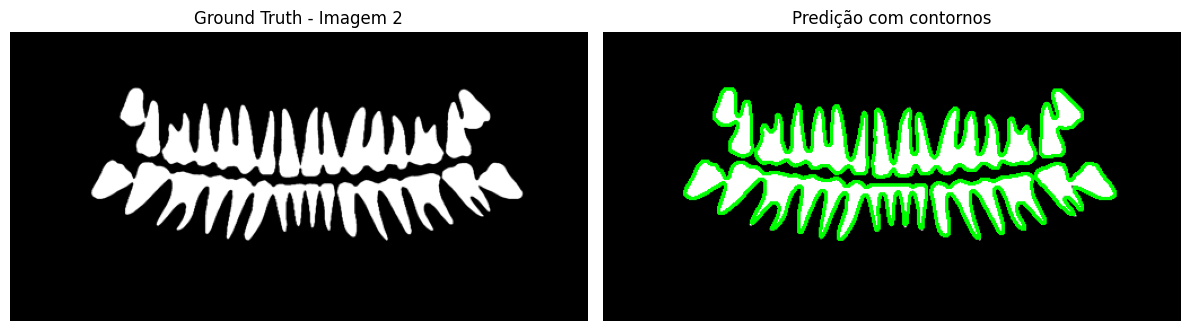

In [ ]:
# 1. Upload dos arquivos
print("Faça upload de 5 máscaras:")
uploaded = files.upload()
file_paths = list(uploaded.keys())

# 2. Transforma e prepara as imagens
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

class MaskDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')
        input_tensor = self.transform(img)
        target_tensor = (input_tensor > 0.5).float()  # binarização
        return input_tensor, target_tensor

# 3. Separar treino e teste (3 treino, 2 teste)
train_files = file_paths[:3]
test_files = file_paths[3:]

train_dataset = MaskDataset(train_files, transform)
test_dataset = MaskDataset(test_files, transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 4. Modelo U-Net simples
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.enc1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.out_conv = nn.Conv2d(8, 1, kernel_size=1)

    def forward(self, x):
        x1 = F.relu(self.enc1(x))
        x2 = F.relu(self.enc2(self.pool(x1)))
        x3 = F.relu(self.dec1(self.up(x2)))
        x4 = torch.sigmoid(self.out_conv(x3))
        return x4

# 5. Inicializar modelo, critério, otimizador
model = SimpleUNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 6. Treinamento
for epoch in range(50):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss médio: {epoch_loss/len(train_loader):.4f}")

# 7. Avaliação
model.eval()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        print(f"Teste {i+1}: Loss = {loss.item():.4f}")

        # 8. Visualização com contornos
        pred = outputs.squeeze().numpy()
        pred_bin = (pred > 0.5).astype(np.uint8) * 255
        contours, _ = cv2.findContours(pred_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        test_img = np.array(Image.open(test_files[i]).resize((512, 256)))
        img_color = cv2.cvtColor(test_img, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img_color, contours, -1, (0, 255, 0), thickness=2)

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(test_img, cmap='gray')
        axs[0].set_title(f"Ground Truth - Imagem {i+1}")
        axs[1].imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Predição com contornos")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()